In [1]:
# !apt-get update && apt-get install libsm6 libxext6 -y -qq
# !apt-get install libgl1-mesa-glx graphviz -y -qq
# !pip install -r requirements.txt -q
# import os
# os._exit(0)
# # # !apt-get install unrar

# IMPORT PACKAGES

In [2]:
import os
import shutil
import PIL
import numpy as np
import cv2
import zipfile
from PIL import Image
import tensorflow as tf
import pandas as pd
import pathlib
import natsort
import sys

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
%load_ext autotime

print(tf.__version__)
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
2.15.0
time: 1.03 ms (started: 2024-11-30 08:48:08 +00:00)


In [41]:
EPOCHS = 1000
BATCH = 16
ETA = 0.001
WEIGHT_DECAY = 6e-8
IMAGE_SHAPE = (512, 1024, 1)
MASK_SHAPE = (512, 1024, 1)
model_path = '/notebooks/saved_models'

time: 601 µs (started: 2024-11-30 04:53:06 +00:00)


In [42]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Enable GPU memory growth (optional)
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    # Set mixed precision policy
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow GPU device: ", tf.test.gpu_device_name())
print("All devices: ", tf.config.list_physical_devices())

Num GPUs Available:  1
TensorFlow GPU device:  /device:GPU:0
All devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
time: 1.63 ms (started: 2024-11-30 04:53:07 +00:00)


2024-11-30 04:53:07.819115: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-30 04:53:07.819301: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-30 04:53:07.819380: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# READ DATASET (IMAGES, MASKS)

In [43]:
class readDataset:
    def __init__(self, imagesPathes, masksPathes):
        self.imagesPathes = imagesPathes
        self.masksPathes = masksPathes
        self.images = None
        self.masks = None
        self.val_images = None
        self.val_masks = None
        self.test_images = None
        self.test_masks = None
        
    def readPathes(self,):
        self.images = natsort.natsorted(list(pathlib.Path(self.imagesPathes).glob('*.*')))
        self.masks = natsort.natsorted(list(pathlib.Path(self.masksPathes).glob('*.*')))
        try:
            shutil.rmtree(os.path.join(self.imagesPathes, ".ipynb_checkpoints"))
            shutil.rmtree(os.path.join(self.masksPathes, ".ipynb_checkpoints"))
            print(f".ipynb_checkpoints directory deleted successfully.")
        except Exception as e:
            print(f"just checking .ipynb_checkpoints (nothing)")
        
    def readImages(self, data, typeData):
        images = []
        height = 512
        width = 1024
        for img in data:
            img_name = img.name
            img = cv2.imread(str(img), 0)
            img = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)
            if typeData == 'm':
                img = np.where(img > 0, 1, 0)            
            img = np.expand_dims(img, axis=-1)
            images.append(img)
        print("(INFO..) Read Image Done")
        return np.array(images)

    def normalizeImages(self, images):
        normalized_images = []
        clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(3,3))
        for img in images:
            img = clahe.apply(img)
            img = img.astype(np.float32)
            img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255 #scaler
            # img = np.clip(img, 0, 255).astype(np.uint8)  #set all pixel to [0,255]
            img = img / 255.
            img = np.expand_dims(img, axis=-1)
            normalized_images.append(img)
        print("(INFO..) Normalization Image Done")
        return np.array(normalized_images)
            
    def dataAugmentation(self, images, masks):
        if len(images) != len(masks):
            raise ValueError("Number of images and masks must be the same.")
        imagesupdate = []
        masksupdate = []
        for image, mask in zip(images, masks):
            for aug in range(2):
                imageup = image
                maskup = mask
                if aug == 1:
                    imageup = tf.image.flip_left_right(imageup)
                    maskup = tf.image.flip_left_right(maskup)
                imagesupdate.append(imageup), masksupdate.append(maskup)
                
        imagesupdate2 = []
        masksupdate2 = []
        for image, mask in zip(imagesupdate, masksupdate):
            contrast_factor = tf.random.uniform([], 0.3, 3)
            for aug in range(2):
                imageup = image
                maskup = mask
                if aug == 1:
                    imageup = tf.image.adjust_contrast(imageup, contrast_factor)
                    maskup_np = tf.make_ndarray(tf.make_tensor_proto(maskup))
                    maskup_np = maskup_np.copy()
                    maskup = tf.convert_to_tensor(maskup_np, dtype=tf.float32)
                imagesupdate2.append(imageup), masksupdate2.append(maskup)
        
        imagesupdate3 = []
        masksupdate3 = []
        for image, mask in zip(imagesupdate2, masksupdate2):
            brightness_delta = tf.random.uniform([], -0.45, 0.55)
            for aug in range(2):
                imageup = image
                maskup = mask
                if aug == 1:
                    imageup = tf.image.adjust_brightness(imageup, delta=brightness_delta)
                    maskup_np = tf.make_ndarray(tf.make_tensor_proto(maskup))
                    maskup_np = maskup_np.copy()
                    maskup = tf.convert_to_tensor(maskup_np, dtype=tf.float32)
                imagesupdate3.append(imageup), masksupdate3.append(maskup)
    
        print("(INFO..) Augmentation Image Done")
        return np.array(imagesupdate3), np.array(masksupdate3)
    
    def splitDataset(self, images, masks, val_size=0.1, test_size=0.1, random_state=42):
        data = list(zip(images, masks))
        train_data, test_data = train_test_split(data, test_size=(val_size + test_size), random_state=random_state)
        val_data, test_data = train_test_split(test_data, test_size=(test_size / (val_size + test_size)), random_state=random_state)

        train_images, train_masks = zip(*train_data)
        val_images, val_masks = zip(*val_data)
        test_images, test_masks = zip(*test_data)
        print("(INFO..) Splitting Data Done")
        return np.array(train_images), np.array(train_masks), np.array(val_images), np.array(val_masks), np.array(test_images), np.array(test_masks)

time: 2.75 ms (started: 2024-11-30 04:53:09 +00:00)


In [44]:
datasetObject = readDataset("/notebooks/Childrens dental segmentation dataset version 2/images",
                           "/notebooks/Childrens dental segmentation dataset version 2/mask")
datasetObject.readPathes()
images = datasetObject.readImages(datasetObject.images, 'i')
masks = datasetObject.readImages(datasetObject.masks, 'm')

trainImages, trainMasks, validImages, validMasks, testImages, testMasks = datasetObject.splitDataset(images=images, masks=masks, val_size=20, test_size=10)
trainImages, trainMasks = datasetObject.dataAugmentation(trainImages, trainMasks)

trainImages = datasetObject.normalizeImages(trainImages)
validImages = datasetObject.normalizeImages(validImages)
testImages = datasetObject.normalizeImages(testImages)

just checking .ipynb_checkpoints (nothing)
(INFO..) Read Image Done
(INFO..) Read Image Done
(INFO..) Splitting Data Done
(INFO..) Augmentation Image Done
(INFO..) Normalization Image Done
(INFO..) Normalization Image Done
(INFO..) Normalization Image Done
time: 29.4 s (started: 2024-11-30 04:53:12 +00:00)


In [45]:
trainMasks = np.squeeze(trainMasks, axis=-1)
validMasks = np.squeeze(validMasks, axis=-1)
testMasks = np.squeeze(testMasks, axis=-1)

print(f"Data Train: {trainImages.shape}, {trainMasks.shape}")
print(f"Data Validation: {validImages.shape}, {validMasks.shape}")
print(f"Data Test: {testImages.shape}, {testMasks.shape}")

Data Train: (1304, 512, 1024, 1), (1304, 512, 1024)
Data Validation: (20, 512, 1024, 1), (20, 512, 1024)
Data Test: (10, 512, 1024, 1), (10, 512, 1024)
time: 580 µs (started: 2024-11-30 04:53:41 +00:00)


In [46]:
np.unique(trainMasks), np.min(trainImages), np.max(trainImages), np.min(trainMasks), np.max(trainMasks)

(array([0., 1.]), 0.0, 1.0, 0.0, 1.0)

time: 24 s (started: 2024-11-30 04:53:41 +00:00)


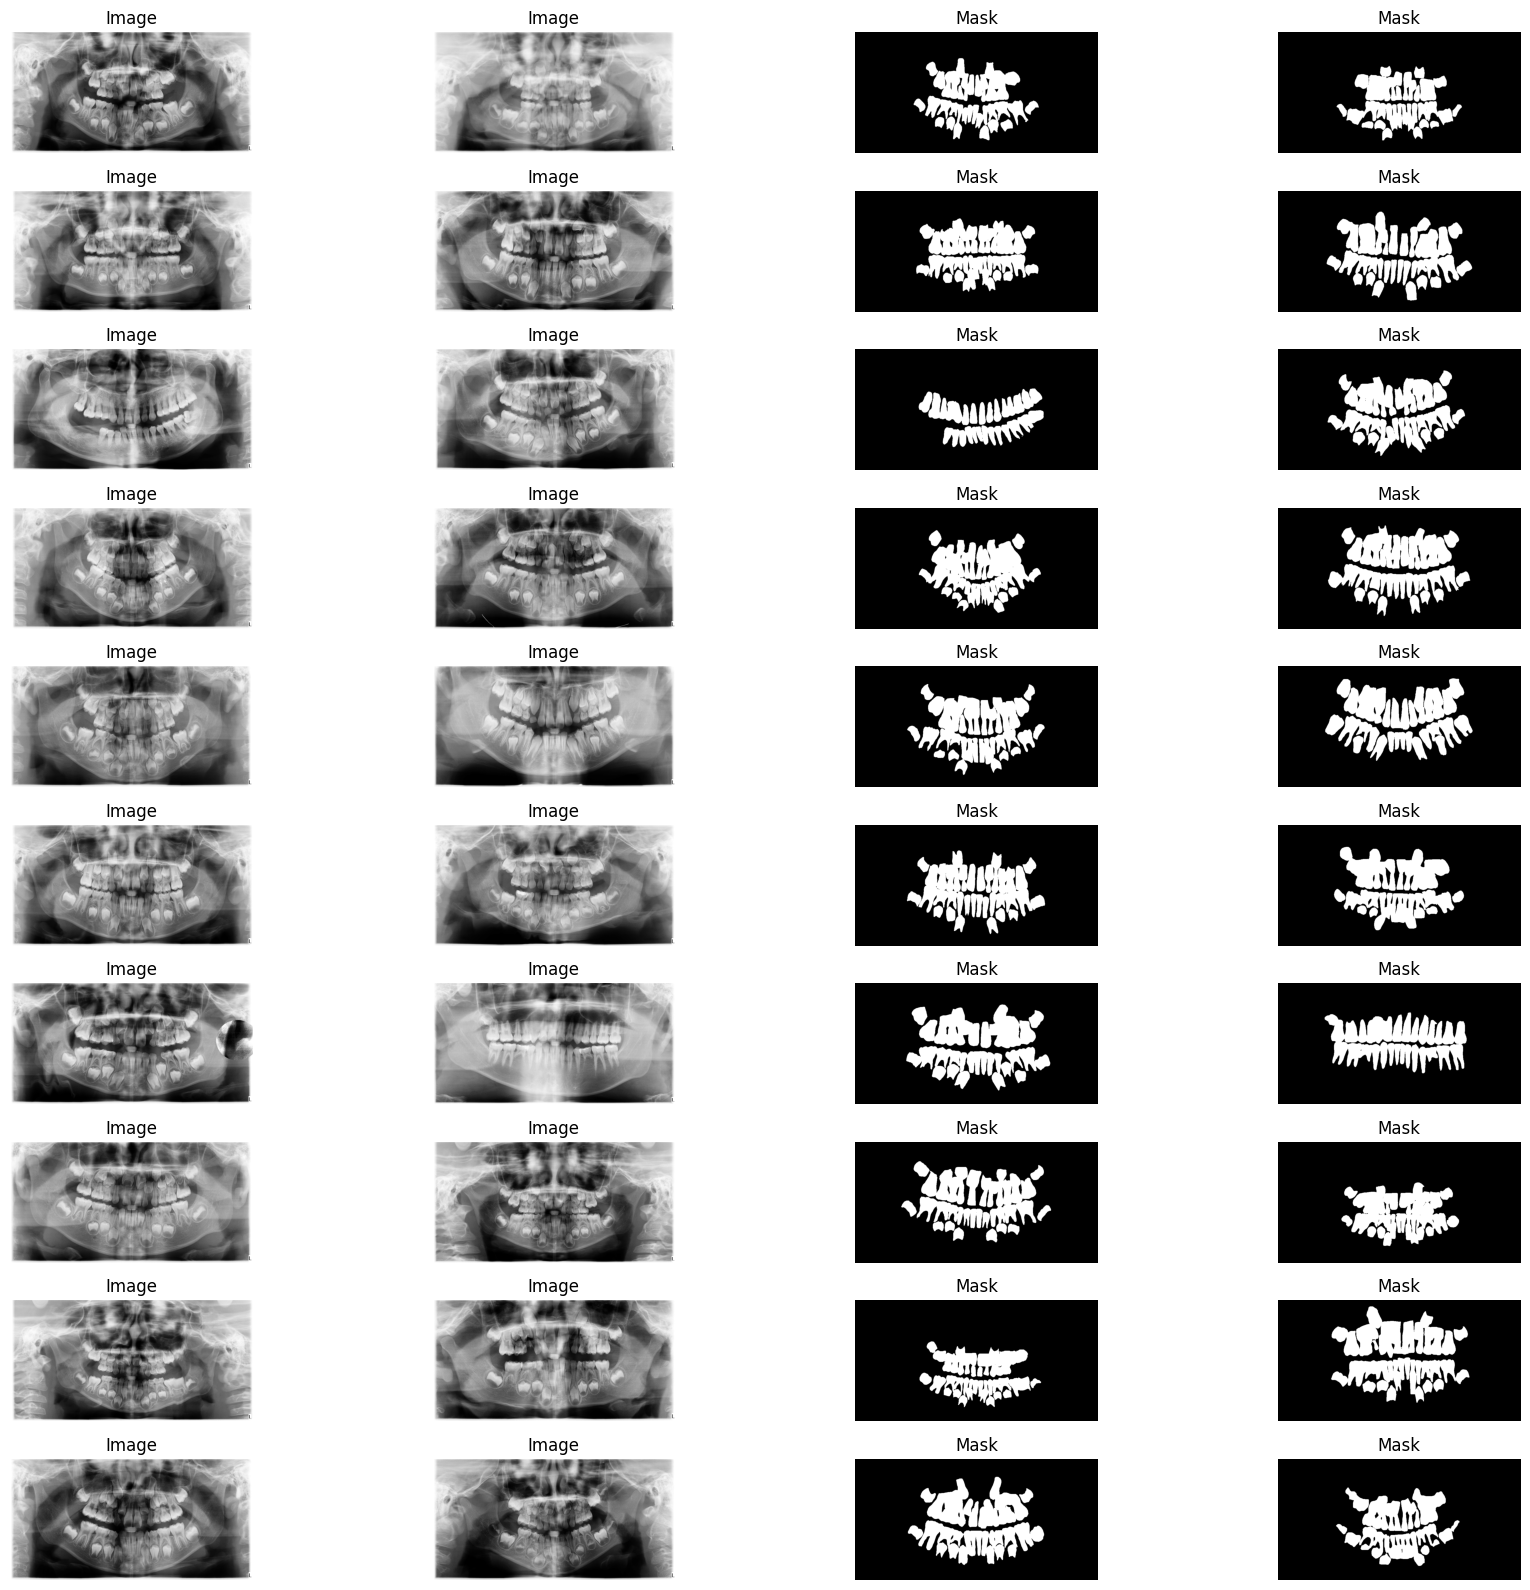

time: 2.58 s (started: 2024-11-30 04:54:05 +00:00)


In [47]:
plt.figure(figsize=(18, 16))
gs = gridspec.GridSpec(20 // 2, 4, width_ratios=[1, 1, 1, 1])
for i in range(20):
    ax0 = plt.subplot(gs[i // 2, i % 2])
    ax1 = plt.subplot(gs[i // 2, i % 2 + 2])
    ax0.imshow(validImages[i], cmap='gray', aspect='auto')
    ax1.imshow(validMasks[i], cmap='gray', aspect='auto')
    ax0.set_title('Image')
    ax1.set_title('Mask')
    ax0.axis('off')
    ax1.axis('off')
    ax0.set_aspect('equal')
    ax1.set_aspect('equal')
plt.tight_layout()
plt.show()

# Define Dice Loss

In [49]:
def dice_score(y_true, y_pred, threshold=0.5):
    smooth = 1.
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), dtype=tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred >= threshold, [-1]), dtype=tf.float32)
    intersection = y_true_f * y_pred_f
    score = (2. * tf.reduce_sum(intersection) + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1. - dice_score(y_true, y_pred)
    return tf.cast(loss, dtype=tf.float32)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return tf.cast(bce, dtype=tf.float32) + dice

def bfce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryFocalCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return tf.cast(bce, dtype=tf.float32) + dice

def binaryIoU_loss(y_true, y_pred):
    IoU =  tf.keras.metrics.BinaryIoU()(y_true, y_pred)
    return 1 - IoU

time: 1.01 ms (started: 2024-11-30 04:54:33 +00:00)


# Proposing a generative neural network architecture

In [50]:
def convolution(input, filter, padding, strides, kernel, activation, conv_type, name_prefix=''):
    initializer = tf.random_normal_initializer(0., 0.02)
    x = input
    x = layers.Conv2D(filter, kernel_size=kernel, padding=padding, strides=strides, 
                      kernel_initializer=initializer, use_bias=False, name=f'{name_prefix}_conv1')(x)
    x = layers.GroupNormalization(groups=filter, name=f'{name_prefix}_gn1')(x)
    
    if conv_type == 'decoder':
        x = layers.Activation(activation, name=f'{name_prefix}_activation1')(x)
        x = layers.Conv2D(filter*2, kernel_size=kernel, padding=padding, strides=strides, 
                          kernel_initializer=initializer, use_bias=False, name=f'{name_prefix}_conv2')(x)
        x = layers.GroupNormalization(groups=filter*2, name=f'{name_prefix}_gn2')(x)
        x = layers.Activation(activation, name=f'{name_prefix}_activation2')(x)
        x = layers.Conv2D(filter, kernel_size=kernel, padding=padding, strides=strides, 
                          kernel_initializer=initializer, use_bias=False, name=f'{name_prefix}_conv3')(x)
        x = layers.GroupNormalization(groups=filter, name=f'{name_prefix}_gn3')(x)
    
    x = layers.average([x, layers.Conv2D(filter, kernel_size=1, padding='same', strides=1, kernel_initializer=initializer, name=f'{name_prefix}_conv4')(input)], name=f'{name_prefix}_?')
    x = layers.Activation(activation, name=f'{name_prefix}_activation3')(x)
    return x

time: 979 µs (started: 2024-11-30 04:54:35 +00:00)


In [51]:
def encoder(input, filter, padding, strides, kernel, activation, name_prefix):
    x = input
    x = convolution(x, filter, padding, strides, kernel, activation, 'encoder', name_prefix=name_prefix)
    downsample = layers.AveragePooling2D(pool_size=(2, 2), name=f'{name_prefix}_pool')(x)
    return downsample, x

time: 443 µs (started: 2024-11-30 04:54:36 +00:00)


In [52]:
def decoder(input, filter, skip, padding, strides, kernel, activation, name_prefix, dropout=False):
    x = input
    initializer = tf.random_normal_initializer(0., 0.02)
    x = layers.Conv2DTranspose(filter, padding = padding, kernel_size = kernel,
                               activation=activation, strides = 2, kernel_initializer=initializer,
                               use_bias=False, name=f'{name_prefix}_transpose')(x)
    
    if dropout:
        x = layers.Dropout(0.5, name=f'{name_prefix}_dropout')(x)
    x = layers.average([x, skip], name=f'{name_prefix}_skip_connection')
    x = convolution(x, filter, padding, strides, kernel, activation, 'decoder', name_prefix=name_prefix)
    return x

time: 622 µs (started: 2024-11-30 04:54:37 +00:00)


In [53]:
def bottleneck(input, filters_bottleneck, strides, kernel, activation, depth=6, mode='cascade', name_prefix=''):
    dilated_layers = []
    x = input
    if mode == 'cascade':
        for i in range(depth):
            residual = x
            x = layers.Conv2D(filters_bottleneck, kernel_size=kernel, strides=strides,
                               activation=activation, padding='same', dilation_rate=2**i,
                              kernel_initializer=tf.random_normal_initializer(0., 0.02), name=f'{name_prefix}_conv_{i+1}')(x)
            dilated_layers.append(x)
        x = layers.add(dilated_layers, name=f'{name_prefix}_dilated_layers')
        x = layers.GroupNormalization(groups=filters_bottleneck, name=f'{name_prefix}_gn')(x)
        return x
    
    elif mode == 'cascade_residual':
        for i in range(depth):
            residual = x  # Save the input for the residual connection
            x = layers.Conv2D(filters_bottleneck, kernel_size=kernel, strides=strides,
                              activation=activation, padding='same', dilation_rate=2**i,
                              kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
            dilated_layers.append(x)
            if i % 2 == 0:  # Add residual connection only on even convolutional layers
                # Add a 1x1 convolution to the residual connection to match shapes
                residual = layers.Conv2D(filters_bottleneck, kernel_size=(1, 1), strides=strides,
                                         padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))(residual)
                residual = layers.GroupNormalization(groups=filters_bottleneck)(residual)
                # Add the residual connection
                x = layers.add([x, residual])
            
        cascade_layer = layers.add(dilated_layers)
        fusion = layers.add([cascade_layer, x])
        fusion = layers.GroupNormalization(groups=filters_bottleneck)(fusion)
        return fusion
    
    elif mode == 'cascade_residual_multidimension':
        for i in range(depth):
            residual = x 
            x = layers.Conv2D(filters_bottleneck, kernel_size=kernel, strides=strides,
                               activation=activation, padding='same', dilation_rate=2**i,
                              kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
            dilated_layers.append(x)
            residual = layers.Conv2D(filters_bottleneck, kernel_size=(1, 1), strides=strides,
                                     padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))(residual)
            residual = layers.GroupNormalization(groups=filters_bottleneck)(residual)
            x = layers.add([x, residual])
            dilated_layers.append(x)
        fusion = layers.add(dilated_layers)
        fusion = layers.GroupNormalization(groups=filters_bottleneck)(fusion)
        return fusion
    
    elif mode == 'parallel':  # Like "Atrous Spatial Pyramid Pooling"
        for i in range(depth):
            dilated_layers.append(
                layers.Conv2D(filters_bottleneck, kernel_size=kernel,
                       activation=activation, padding='same', dilation_rate=2**i)(x)
            )
        parallel = layers.add(dilated_layers) 
        parallel = layers.GroupNormalization(groups=filters_bottleneck)(parallel)
        return parallel

time: 1.93 ms (started: 2024-11-30 04:54:39 +00:00)


In [54]:
def generator(input, filter, padding, strides, kernel, model_weights, weights_path=''):
    x = input
    con1, skip1 = encoder(x, filter, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='encoder1')
    con2, skip2 = encoder(con1, filter*2, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='encoder2')
    con3, skip3 = encoder(con2, filter*4, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='encoder3')
    con4, skip4 = encoder(con3, filter*8, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='encoder4')
    deco1 = decoder(con4, filter*8, skip4, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(0.2), name_prefix='decoder1')
    deco2 = decoder(deco1, filter*4, skip3, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(0.2), name_prefix='decoder2')
    deco3 = decoder(deco2, filter*2, skip2, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(0.2), name_prefix='decoder3')
    deco4 = decoder(deco3, filter, skip1, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(0.2), name_prefix='decoder4')
    
    initializer = tf.random_normal_initializer(0., 0.02)
    output = layers.Conv2DTranspose(1, kernel_size=kernel, strides=strides, padding=padding, 
                                    kernel_initializer=initializer, activation='sigmoid', 
                                    name='generator_output_layer')(deco4)
    
    generator = models.Model(inputs=input, outputs=output, name='generator')
    
    if model_weights is not None:
        generator.load_weights(weights_path)
    generator.summary()
    return generator

time: 975 µs (started: 2024-11-30 04:54:41 +00:00)


In [55]:
generator = generator(input=layers.Input(shape = IMAGE_SHAPE), filter=32, padding='same', kernel=3, strides=1, 
                            model_weights=None, 
                            weights_path="")

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 1024, 1)]       0         []                            
                                                                                                  
 encoder1_conv1 (Conv2D)     (None, 512, 1024, 32)        288       ['input_1[0][0]']             
                                                                                                  
 encoder1_gn1 (GroupNormali  (None, 512, 1024, 32)        64        ['encoder1_conv1[0][0]']      
 zation)                                                                                          
                                                                                                  
 encoder1_conv4 (Conv2D)     (None, 512, 1024, 32)        64        ['input_1[0][0]']     

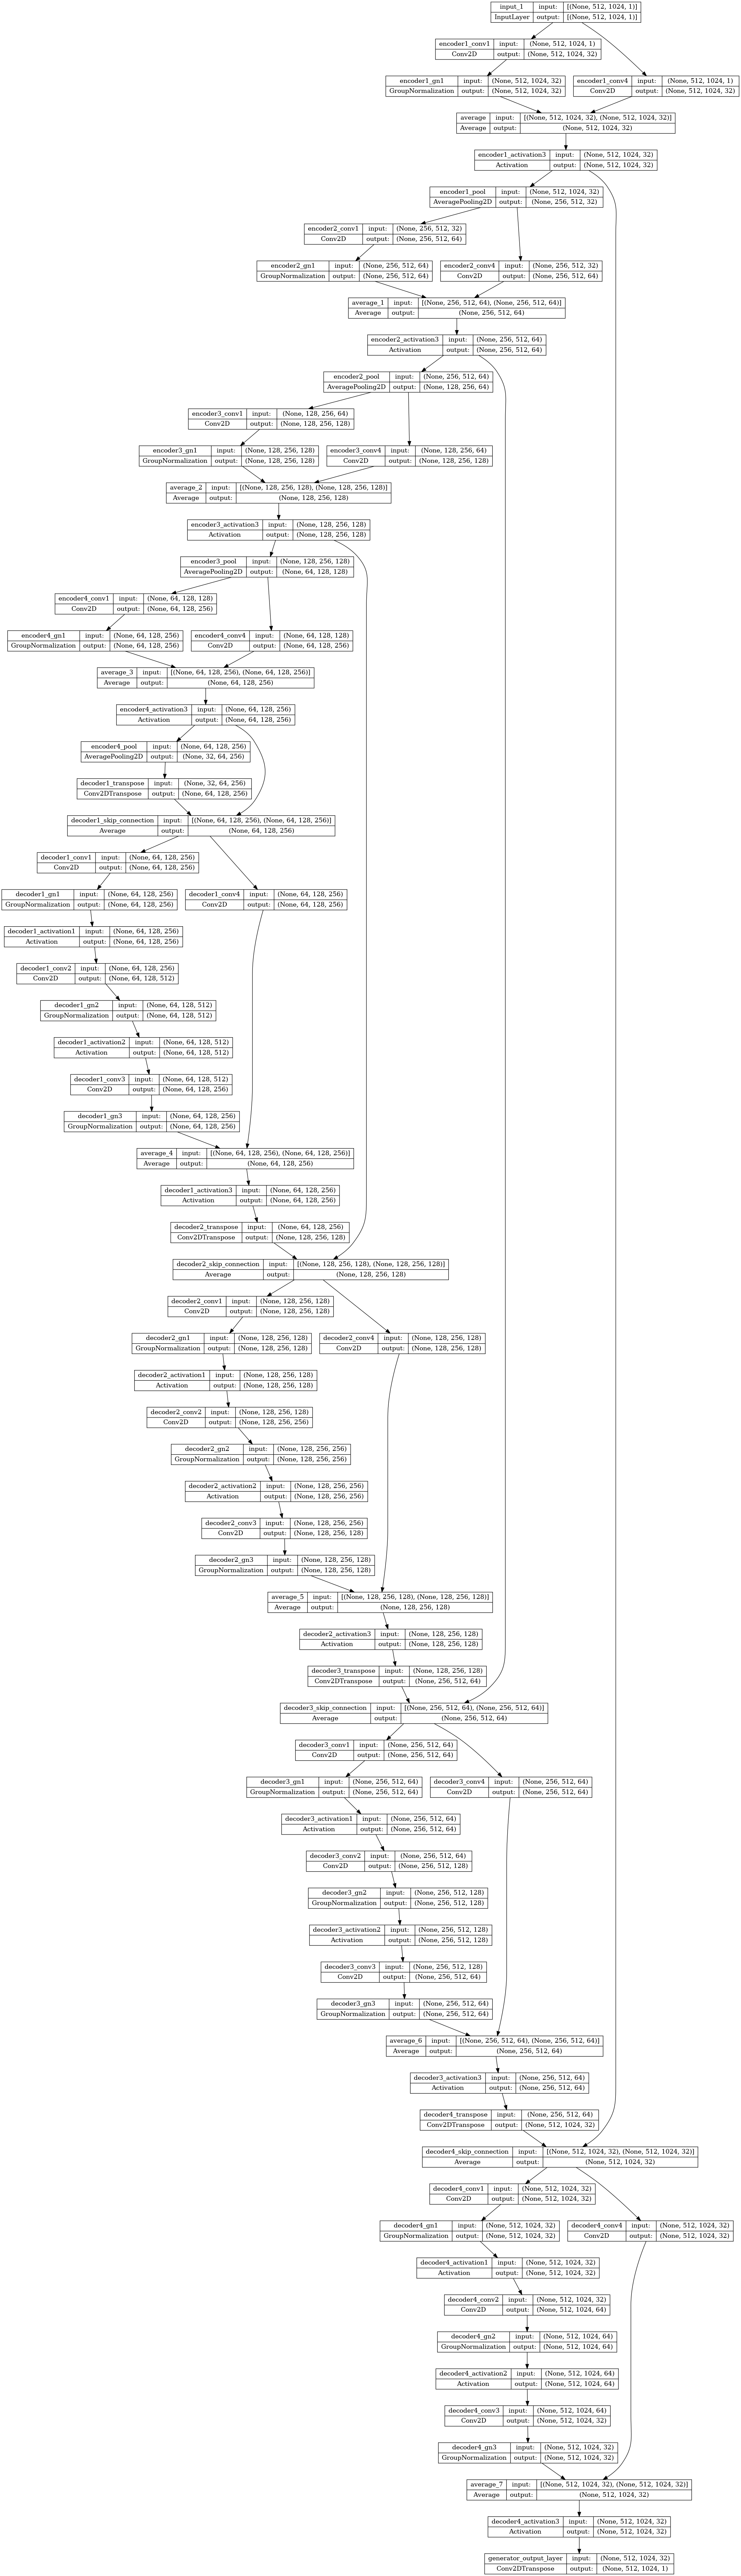

time: 848 ms (started: 2024-11-30 04:55:22 +00:00)


In [56]:
tf.keras.utils.plot_model(generator, show_shapes = True, show_layer_names=True, to_file='./chart/generator.png')

In [58]:
def discriminator(ImageInput, maskInput, filter, padding, strides, kernel, lossFn, learning_rate, weight_decay, model_weights, weights_path=''):
    x = layers.multiply([ImageInput, maskInput])
    con1, skip1 = encoder(x, filter, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='disc_encoder1')
    con2, skip2 = encoder(con1, filter*2, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='disc_encoder2')
    con3, skip3 = encoder(con2, filter*4, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='disc_encoder3')
    con4, skip4 = encoder(con3, filter*8, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='disc_encoder4')
    x = layers.GlobalAveragePooling2D()(con4)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(1)(x)
    discriminator = models.Model(inputs=[maskInput, ImageInput], outputs=x, name='discriminator')
    if model_weights is not None:
        discriminator.load_weights(weights_path)
    discriminator.compile(loss=lossFn, loss_weights=[1],
                          optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, weight_decay=weight_decay),)
    discriminator.summary()
    return discriminator

time: 834 µs (started: 2024-11-30 04:55:35 +00:00)


In [59]:
discriminator = discriminator(ImageInput=layers.Input(shape=IMAGE_SHAPE), 
                                    maskInput=layers.Input(shape=MASK_SHAPE),
                                    filter=32, padding = 'same', strides=1, kernel=3, 
                                    lossFn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                                    learning_rate=ETA, weight_decay=WEIGHT_DECAY,
                                    model_weights=None, 
                                    weights_path="")

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 1024, 1)]       0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 512, 1024, 1)]       0         []                            
                                                                                                  
 multiply (Multiply)         (None, 512, 1024, 1)         0         ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 disc_encoder1_conv1 (Conv2  (None, 512, 1024, 32)        288       ['multiply[0][0]']

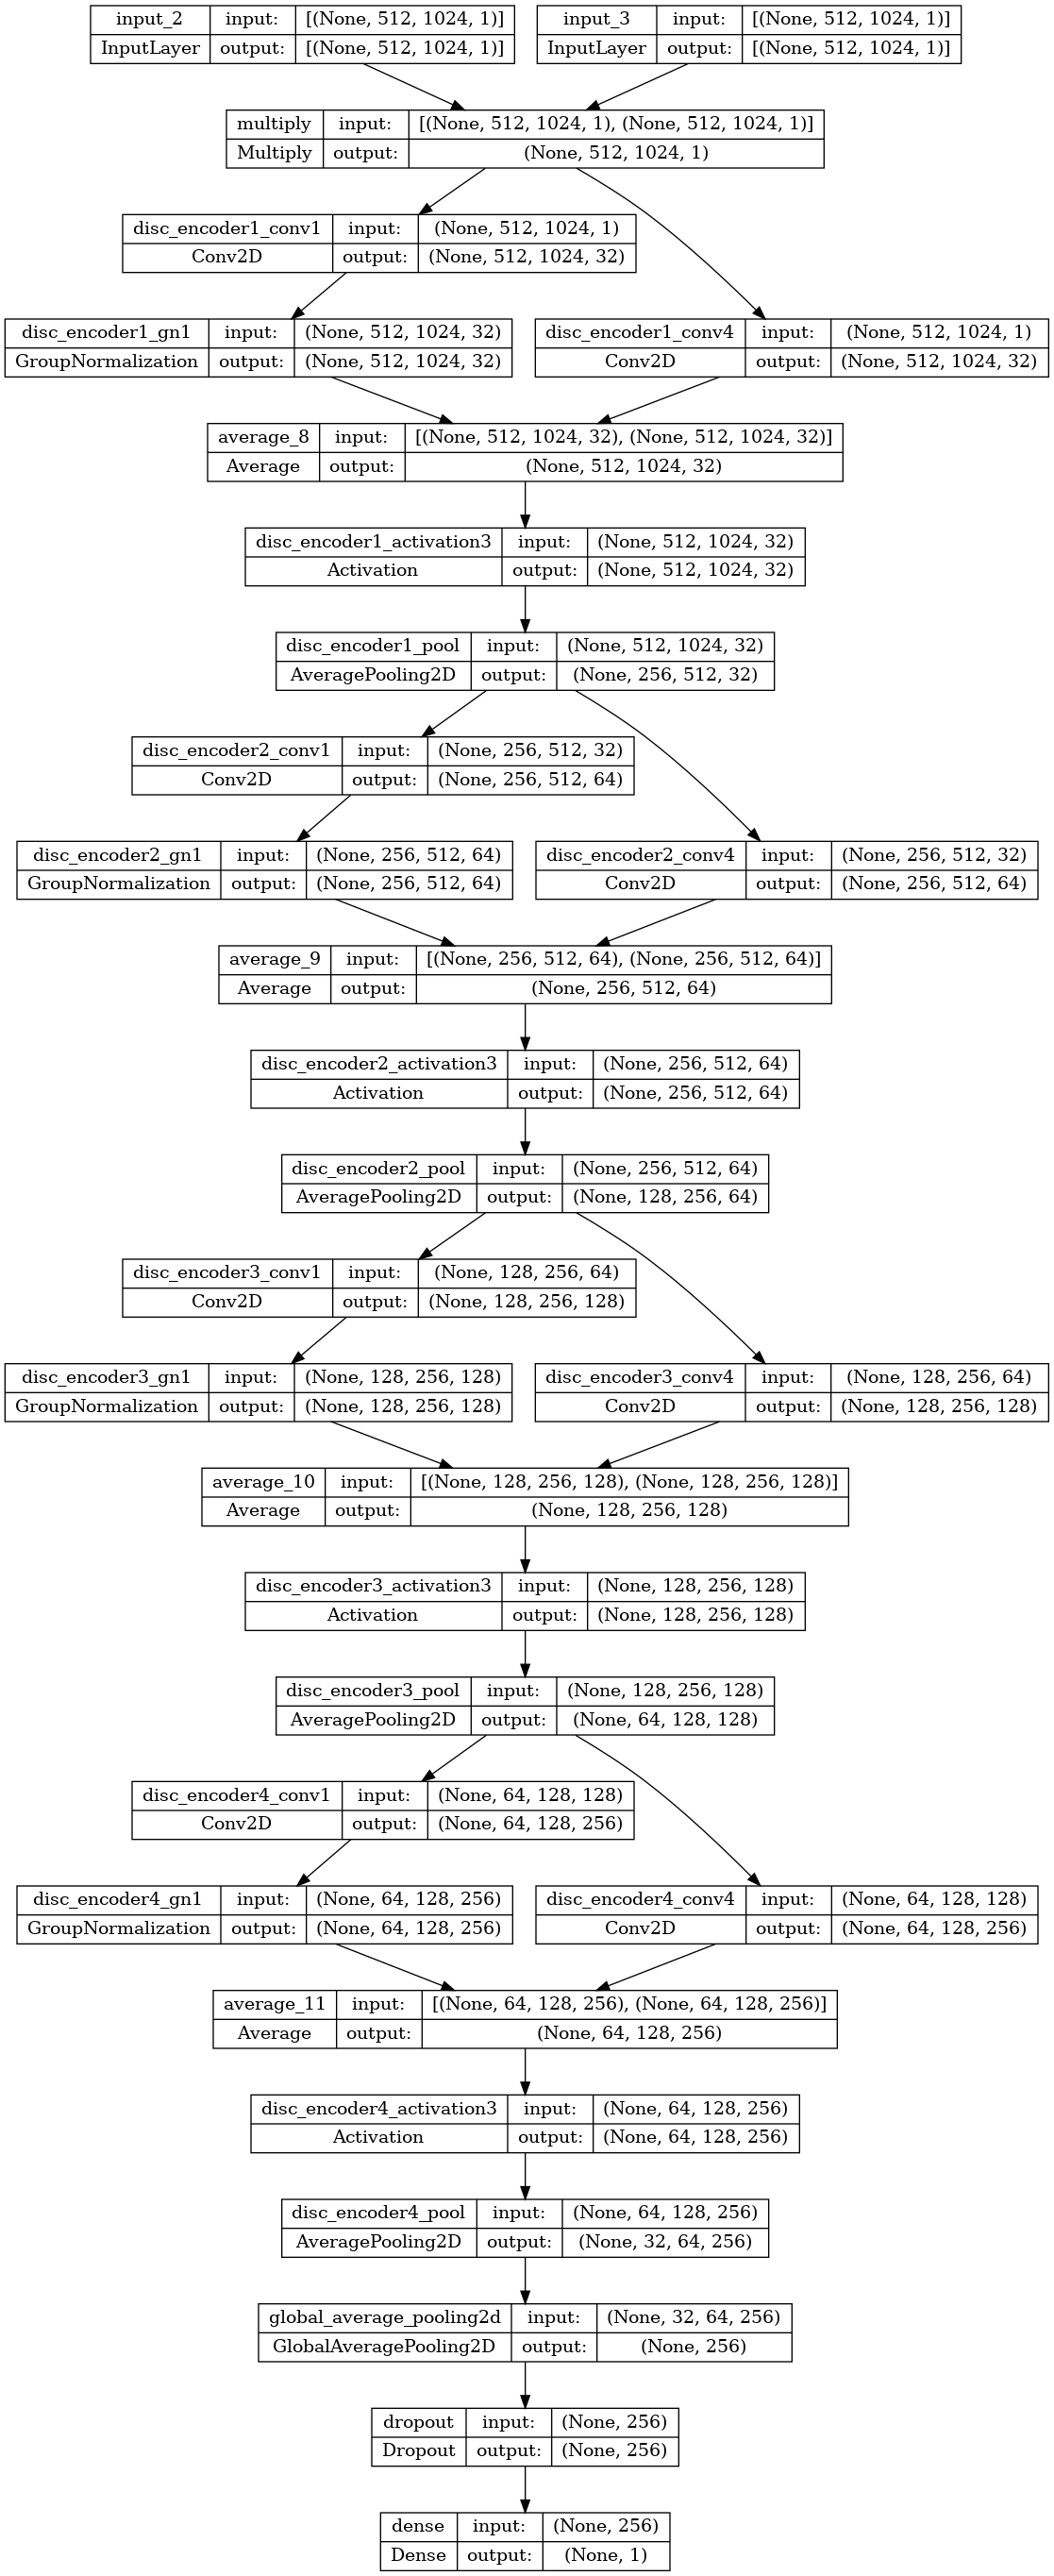

time: 193 ms (started: 2024-11-30 04:55:38 +00:00)


In [60]:
tf.keras.utils.plot_model(discriminator, show_shapes = True, show_layer_names=True, to_file='./chart/discriminator.png')

In [61]:
def GAN(discriminator, generator, learning_rate, weight_decay, lossFn):
    imageInput=layers.Input(shape=IMAGE_SHAPE, name="image_Input")
    maskInput=layers.Input(shape=MASK_SHAPE, name="mask_Input")
    
    discriminator.trainable = False
    
    fakeMasks = generator(imageInput)
    discriminatorInput = discriminator([fakeMasks, imageInput])
    
    gan = models.Model(inputs=[maskInput, imageInput],
                       outputs=[discriminatorInput, fakeMasks],
                       name='cgan')
    
    gan.compile(loss=lossFn, loss_weights=[1,100], 
                optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate*0.5, weight_decay=weight_decay*0.5),
                metrics=tf.keras.losses.BinaryCrossentropy(from_logits=True))
    gan.summary()
    return gan

time: 643 µs (started: 2024-11-30 04:55:45 +00:00)


In [62]:
gan = GAN(discriminator=discriminator, generator=generator,
          learning_rate=ETA, weight_decay=WEIGHT_DECAY, 
          lossFn=[tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 'mae'])

# Notes the loss functions is (log BCE + MAE * 100(lambda))
# Following the isola et al loss functions 

Model: "cgan"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_Input (InputLayer)    [(None, 512, 1024, 1)]       0         []                            
                                                                                                  
 generator (Functional)      (None, 512, 1024, 1)         5417185   ['image_Input[0][0]']         
                                                                                                  
 mask_Input (InputLayer)     [(None, 512, 1024, 1)]       0         []                            
                                                                                                  
 discriminator (Functional)  (None, 1)                    432097    ['generator[0][0]',           
                                                                     'image_Input[0][0]']      

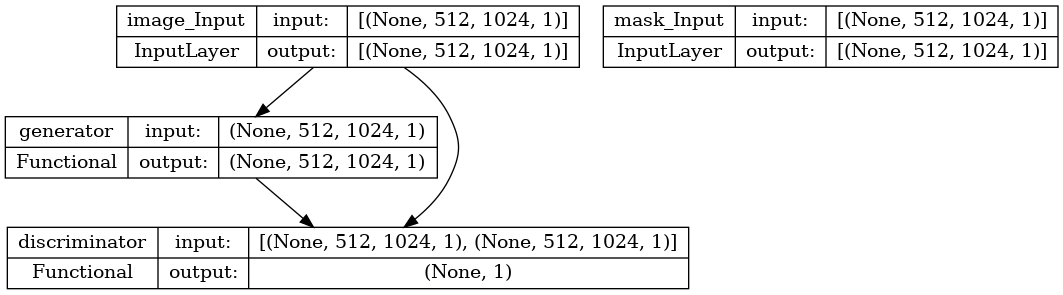

time: 42.1 ms (started: 2024-11-30 04:55:48 +00:00)


In [63]:
tf.keras.utils.plot_model(gan, show_shapes = True, show_layer_names=True, to_file='./chart/gan.png')

In [64]:
def samples(generator, images, realMasks):
    predMasks = tf.squeeze(generator.predict(images, verbose=0))
    plt.figure(figsize=(12,6))
    for i in range(3):
        plt.subplot(3, 3, i * 3 + 1)
        plt.title('Input Image')
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')

        plt.subplot(3, 3, i * 3 + 2)
        plt.title('Ground Truth')
        plt.imshow(realMasks[i], cmap='gray')
        plt.axis('off')

        plt.subplot(3, 3, i * 3 + 3)
        plt.title('Predicted Mask')
        plt.imshow(predMasks[i], cmap='gray')
        plt.axis('off')
    plt.show()

time: 648 µs (started: 2024-11-30 04:57:03 +00:00)


In [65]:
tf.keras.backend.clear_session()

time: 89.7 ms (started: 2024-11-30 04:57:04 +00:00)


In [66]:
dlossTagList = []
glossTagList = []

for epoch in range(EPOCHS):
    indexs = np.random.randint(0, len(trainImages), size = (BATCH, ))
    realImages = trainImages[indexs]
    realMasks = trainMasks[indexs]
    realTag = tf.ones(shape = (BATCH, ))

    fakeMasks = tf.squeeze(generator.predict([realImages], verbose=0))    
    fakeTag = tf.zeros(shape = (BATCH, ))
    
    allTags = np.hstack([realTag, fakeTag])
    allMasks = np.vstack([realMasks, fakeMasks])
    allImages = np.vstack([realImages, realImages])
    dlossTag = discriminator.train_on_batch([allMasks, allImages], [allTags])
    
    glossTag = gan.train_on_batch([realMasks, realImages], [realTag, realMasks])
    
    dlossTagList.append(dlossTag)
    glossTagList.append(glossTag) 
    if epoch % 200 == 0:
        print(f"Epoch/Epochs: {epoch}/{EPOCHS}")
        print(f"discriminator loss: [tag: {dlossTag}], generator loss: [tag: {glossTag}]")
        validIndexs = np.random.randint(0, len(validImages), size = (3, ))
        samples(generator, validImages[validIndexs], validMasks[validIndexs])  
    elif epoch == EPOCHS-1:
        print(f"Epoch/Epochs: {epoch}/{EPOCHS}")
        print(f"discriminator loss: [tag: {dlossTag}], generator loss: [tag: {glossTag}]")
        validIndexs = np.random.randint(0, len(validImages), size = (3, ))
        samples(generator, validImages[validIndexs], validMasks[validIndexs])  

2024-11-30 05:01:11.521383: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 512.00MiB (rounded to 536870912)requested by op cgan/generator/decoder4_transpose/conv2d_transpose
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-11-30 05:01:11.521477: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-11-30 05:01:11.521478: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 300, Chunks in use: 298. 75.0KiB allocated for chunks. 74.5KiB in use in bin. 24.1KiB client-requested in use in bin.
2024-11-30 05:01:11.521523: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 63, Chunks in use: 62. 32.2KiB allocated for chunks. 31.8KiB in use in bin. 31.1KiB client-

ResourceExhaustedError: Graph execution error:

Detected at node cgan/generator/decoder4_transpose/conv2d_transpose defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/ipykernel_launcher.py", line 17, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 604, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 529, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 518, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 424, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 766, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3046, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3548, in run_code

  File "/tmp/ipykernel_1291/3111952849.py", line 18, in <module>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 2787, in train_on_batch

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/conv2d_transpose.py", line 296, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend.py", line 6268, in conv2d_transpose

OOM when allocating tensor with shape[16,512,1024,32] and type half on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node cgan/generator/decoder4_transpose/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_96938]

time: 4min 4s (started: 2024-11-30 04:57:07 +00:00)


put_ops.cc:412 : RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[16,512,1024,32] and type half on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc


In [ ]:
df = pd.DataFrame(glossTagList, columns=["loss 1", "loss 2", "loss 3", "loss 4", "loss 5"])
df['loss 1'] = df['loss 1'] - df['loss 5']
print(f"min mae index-: {df['loss 1'].idxmin()}")
print(f"min mae: {round(np.min(df['loss 1']),4)}")
print(f"last mae: {round(df['loss 1'].iloc[-1],4)}")

plt.figure(figsize=(12, 6))
plt.plot(dlossTagList, label='Discriminator Loss (Tag)')
plt.plot(df['loss 5'], label='Generator Loss (Tag)')
plt.plot(df['loss 1'], label='L1 Loss (mae)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.show()
plt.savefig('/notebooks/chart/first_loss_chart.png')

In [ ]:
generator_saved = f'4block_RMSprop_swish+leakyrelu_CGAN_{EPOCHS}_clahe_generator.h5'
discriminator_saved = f'4block_RMSprop_swish+leakyrelu_CGAN_{EPOCHS}_clahe_discriminator.h5'

generator_path = os.path.join(model_path, generator_saved)
discriminator_path = os.path.join(model_path, discriminator_saved)

generator.save_weights(generator_path)
discriminator.save_weights(discriminator_path)

- Now we will train the generator again with a number of layers frozen in order to maintain the capacity that the generator has gained.

In [ ]:
weight_path = generator_path

generator2 = generator(input=layers.Input(shape=IMAGE_SHAPE), filter=32, padding='same', kernel=3, strides=1, 
                             model_weights=True, weights_path=weight_path)

for layer in generator2.layers[:20]:
    layer.trainable = False
    
optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5, weight_decay=1e-7)
generator2.compile(loss=bce_dice_loss,
                         optimizer=optimizer, 
                         metrics=[tf.keras.metrics.Precision(name = 'precision'),
                                  tf.keras.metrics.Recall(name = 'recall'), 
                                  tf.keras.metrics.BinaryIoU(name = 'IoU'),
                                  dice_score])

# Evaluate the generator model

In [ ]:
generator2.evaluate(validImages, validMasks)

In [ ]:
generator2.evaluate(testImages, testMasks)

In [ ]:
def draw(images, masks, y_pred):
    plt.figure(figsize = (12, 24))
    index = -1
    n = np.random.randint(y_pred.shape[0])
    for i in range(120):
        plt.subplot(20, 6, (i + 1))
        if index == -1:
            plt.imshow(images[n], cmap = 'gray')
            plt.title('Image')
            plt.axis('off')
            index = 0
        elif index == 0:
            plt.imshow(images[n], cmap = 'gray')
            plt.imshow(masks[n], alpha = 0.6, cmap = 'gray')
            plt.title('Original Mask')
            plt.axis('off')
            index = 1
        elif index == 1:
            plt.imshow(images[n], cmap = 'gray')
            plt.imshow(np.reshape(y_pred[n], IMAGE_SHAPE[:2]), alpha = 0.6, cmap = 'gray')
            plt.title('Predict Mask')
            plt.axis('off')
            index = -1
            n = np.random.randint(y_pred.shape[0])
    plt.legend()

In [ ]:
masks_pred = generator2.predict(validImages, verbose=0)
masks_pred = (masks_pred >= 0.5).astype('int')
masks_pred.shape
draw(validImages, validMasks, masks_pred)

# Re-training of the generator according to the pixel2pixel methodology

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,           # Reduce the learning rate by a factor of 0.2
    patience=3,           # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,
    mode='min',
    min_delta=1e-4,       # minimum changed in monitor metrics
)

history = generator2.fit(trainImages, trainMasks, epochs=200, batch_size=8,
                               validation_data=(validImages, validMasks), verbose=2, 
                               callbacks=[early_stopping, reduce_lr])

# The results obtained

In [ ]:
metrics = ['loss', 'precision', 'recall', 'IoU', 'dice_score']
plt.figure(figsize = (15, 9))
for i in range(5):
    plt.subplot(2, 3, (i + 1))
    plt.plot(history.history['{}'.format(metrics[i])], label = '{}'.format(metrics[i]))
    plt.plot(history.history['val_{}'.format(metrics[i])], label = 'val_{}'.format(metrics[i]))
    plt.title('{}'.format(metrics[i]))
    plt.legend()
plt.savefig('/notebooks/chart/secondtrain_history_chart_1.png')

In [ ]:
metrics = ['precision', 'recall', 'IoU', 'dice_score']
plt.figure(figsize = (12, 8))
for i in range(4):
    plt.subplot(2, 2, (i + 1))
    plt.plot(history.history['{}'.format(metrics[i])], label = '{}'.format(metrics[i]))
    plt.plot(history.history['val_{}'.format(metrics[i])], label = 'val_{}'.format(metrics[i]))
    plt.title('{}'.format(metrics[i]))
    plt.legend()
plt.savefig('/notebooks/chart/secondtrain_history_chart_2.png')

In [ ]:
generator2.evaluate(validImages, validMasks)

In [ ]:
generator2.evaluate(testImages, testMasks)

In [ ]:
generator_path2 = os.path.join(model_path, 'final', f'final_{generator_saved}')
generator2.save(generator_path2)

In [ ]:
generator3 = tf.keras.models.load_model(generator_path2,  
                                        custom_objects={'bce_dice_loss':bce_dice_loss,
                                                        'dice_score': dice_score})

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predIdxs = generator3.predict(validImages)
predIdxs = (predIdxs >= 0.5).astype('int')

validMasks_flat = validMasks.flatten()
predIdxs_flat = predIdxs.flatten()

print("validMasks shape:", validMasks_flat.shape)
print("predIdxs shape:", predIdxs_flat.shape)

class_names = ["Object", "Background"]

print(classification_report(
    validMasks_flat, predIdxs_flat,
    target_names=class_names
))

conf_mat = confusion_matrix(validMasks_flat, predIdxs_flat)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
plt.savefig('/notebooks/chart/secondtrain_confusion_matrix.png')

In [ ]:
masks_pred = generator3.predict(validImages, verbose=0)
masks_pred = (masks_pred >= 0.5).astype('int')
print(masks_pred.shape)
draw(validImages, validMasks, masks_pred)

In [ ]:
masks_pred = generator3.predict(testImages, verbose=0)
masks_pred = (masks_pred >= 0.5).astype('int')
print(masks_pred.shape)
draw(testImages, testMasks, masks_pred)

In [ ]:
masks_pred = generator3.predict(trainImages, verbose=0)
masks_pred = (masks_pred >= 0.5).astype('int')
print(masks_pred.shape)
draw(trainImages, trainMasks, masks_pred)

In [ ]:
import zipfile,os
folder_to_zip = os.path.join(os.getcwd(),'chart')
zip_file_name =  os.path.splitext(generator_saved)[0].replace("_generator", "") + '.zip'
with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for foldername, subfolders, filenames in os.walk(folder_to_zip):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            arcname = os.path.relpath(file_path, folder_to_zip)
            zipf.write(file_path, arcname)
zipf.close()

print(f"{zip_file_name} success zipping...")